## Import

In [ ]:
import os
import glob
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt

import torch
import facer

BASE_DIR = os.path.dirname(os.path.abspath(__file__))
sys.path.append(BASE_DIR)
sys.path.append(os.path.join(BASE_DIR, 'utils'))

# import reference_world as world

# Load metadata

In [ ]:
genki_path = os.path.join(BASE_DIR, 'Datasets/GENKI-4K')
rawPath = os.path.join(genki_path, 'files')

In [ ]:
filenames = []
with open(os.path.join(genki_path, "GENKI-4K_Images.txt"), "r") as f:
    example = f.readlines()
    for line in example:
        filenames.append(line.strip()[-8:])

In [ ]:
labels = []
with open(os.path.join(genki_path, "GENKI-4K_Labels.txt"), "r") as f:
    example = f.readlines()
    for line in example:
        labels.append(int(line.split(' ')[0]))

* Classify class

In [ ]:
smile_files = []
non_smile_files = []

for f, label in zip(filenames, labels) :
    if label == 1 :
        smile_files.append(f)
    elif label == 0 :
        non_smile_files.append(f)

In [ ]:
print(len(smile_files))
print(len(non_smile_files))

2162
1838


# Face detection & segmentation

In [ ]:
savePath = os.path.join(BASE_DIR, 'Datasets/GENKI_seg')

smile_path =  os.path.join(savePath, 'smile')
non_smile_path =  os.path.join(savePath, 'non_smile')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from feat import Detector
# glasses 있는 데이터의 경우 눈 segmentation이 안되어,
# pyfeat detector로 landmarks 추출 후 직접 draw
pyfeat_detector = Detector(
    face_model="RetinaFace",
    landmark_model="MobileNet",
)

45256704it [00:06, 7358577.05it/s]                                                                                                                          
51773440it [00:06, 8017984.90it/s]                                                                                                                          
131072it [00:00, 2666232.51it/s]                                                                                                                            
219136it [00:00, 5093956.80it/s]                                                                                                                            
24646656it [00:03, 6458225.02it/s]                                                                                                                          
20498432it [00:03, 6700810.23it/s]                                                                                                                          


In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
sideface_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_profileface.xml')

In [ ]:
def face_segmentation(image, TARGET_SIZE) :
    resized = cv2.resize(image, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)
    image = facer.hwc2bchw(facer.read_hwc(resized)
                       ).to(device=device)

    face_detector = facer.face_detector('retinaface/mobilenet', device=device)
    with torch.inference_mode():
        faces = face_detector(image)

    _, _, temp = facer.draw_bchw(image, faces, TARGET_SIZE)
    face_detector_arr = facer.show_bchw(temp)

    face_parser = facer.face_parser('farl/celebm', device=device)
    with torch.inference_mode():
        faces = face_parser(image, faces)

    seg_labels, anno_mask_all, seg_arr = facer.draw_bchw(image, faces, TARGET_SIZE)

    l_eye_pts, r_eye_pts = None, None
    if 3 in anno_mask_all :
        detected_faces = np.array(pyfeat_detector.detect_faces(np.array(resized))[0])
        detected_faces = detected_faces.astype(int)
        points = pyfeat_detector.detect_landmarks(np.array(resized), [detected_faces])[0]
        l_eye_pts = np.array(list(map(lambda x: [x[0], x[1]], points[0][36:42])), dtype=np.int32)
        r_eye_pts = np.array(list(map(lambda x: [x[0], x[1]], points[0][42:48])), dtype=np.int32)

        anno_mask_all = cv2.fillPoly(anno_mask_all, [l_eye_pts], 4)
        anno_mask_all = cv2.fillPoly(anno_mask_all, [r_eye_pts], 5)

    anno_mask_face = get_comp(anno_mask_all)

    return resized, anno_mask_all, anno_mask_face

def get_comp(target_mask) :
    canvas = np.zeros_like(target_mask)
    face_comp = [2,4,5,6,7,10,11,12]

    for idx in face_comp :
        canvas[np.where((target_mask == idx))] = idx

    return canvas



*   Smile



In [ ]:
cnt = 0
TARGET_SIZE = (64,64)
for idx, p in enumerate(smile_files) :
    if idx%100==0 :
        print(idx)

      image = cv2.imread(os.path.join(rawPath, 'file'+p))
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      faces = face_cascade.detectMultiScale(gray, 1.3, 5)

      if len(faces) == 0 :
          faces = sideface_cascade.detectMultiScale(gray, 1.3, 5)

      x,y,w,h = faces[0]
      cropped = image[y:y+h, x:x+w]
      resized, anno_mask_all, anno_mask_face = face_segmentation(cropped, TARGET_SIZE)

      cnt += 1
      if cnt %100==0:
          print('SAVE', cnt)

      cv2.imwrite(os.path.join(smile_path, 'images', p), resized)
      cv2.imwrite(os.path.join(smile_path, 'labels', 'all_'+p.split('.')[0]+'.png'), anno_mask_all)
      cv2.imwrite(os.path.join(smile_path, 'labels', 'face_'+p.split('.')[0]+'.png'), anno_mask_face)

* Non-smile

In [ ]:
cnt = 0
for idx, p in enumerate(non_smile_files) :
    TARGET_SIZE = (64,64)
    if idx%100==0 :
        print(idx)

      image = cv2.imread(os.path.join(rawPath, 'file'+p))
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      faces = face_cascade.detectMultiScale(gray, 1.3, 5)

      if len(faces) == 0 :
          faces = sideface_cascade.detectMultiScale(gray, 1.3, 5)

      x,y,w,h = faces[0]
      cropped = image[y:y+h, x:x+w]
      resized, anno_mask_all, anno_mask_face = face_segmentation(cropped, TARGET_SIZE)

      cnt += 1
      if cnt %100==0:
          print('SAVE', cnt)

      cv2.imwrite(os.path.join(non_smile_path, 'images', p), resized)
      cv2.imwrite(os.path.join(non_smile_path, 'labels', 'all_'+p.split('.')[0]+'.png'), anno_mask_all)
      cv2.imwrite(os.path.join(non_smile_path, 'labels', 'face_'+p.split('.')[0]+'.png'), anno_mask_face)

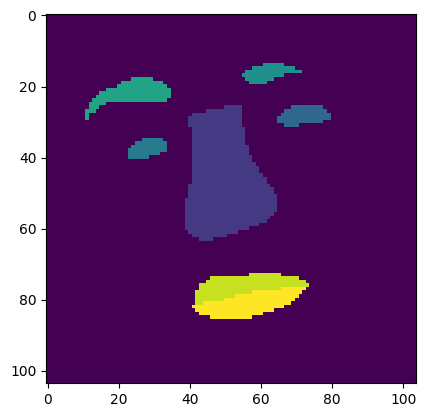

In [ ]:
plt.imshow(anno_mask_face)